In [ ]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Загрузка "обучающего" датасета, из которого будут браться ключевые слова для фраз
data = pd.read_csv('/content/train_data_with_transcriptions.csv')
data.head(2)

,id,text,label,transcription
0,66b066c7-76ff-11ee-93f5-c09bf4619c03_2,протянуть на восемнадцать вагонов,10,NaN
1,88f68b60-76ff-11ee-91db-c09bf4619c03_2,протянуть на восемь вагонов,10,поздно вагонов


array([[<Axes: title={'center': 'label'}>]], dtype=object)

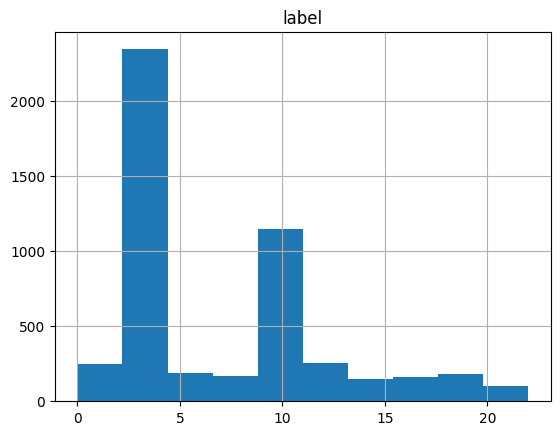

In [ ]:
data.hist(column='label')

In [ ]:
from collections import Counter
import pymorphy3

# Словарь для хранения слов по классам
class_words = {}

# Проходим по каждому классу и собираем слова
for label in data['label'].unique():
    # Извлечение текстов для данного класса
    texts = data[data['label'] == label]['transcription']
    # Объединяем все тексты и очищаем
    all_words = []
    for text in texts:
      if isinstance(text, str):
        all_words.extend(text.split())

    texts = data[data['label'] == label]['text']
    for text in texts:
        all_words.extend(text.split())

    # Подсчет частоты слов
    word_counts = Counter(all_words)
    # Сохраняем наиболее частые слова
    morph = pymorphy3.MorphAnalyzer(lang='ru')

    res = set()
    for word, _ in word_counts.most_common(10):
      parsed =  morph.parse(word)[0]
      if parsed.tag.POS != 'NUMR' and parsed.normal_form != 'вагон':
        res.add(parsed.normal_form)
    class_words[label] = list(res)

# Вывод результатов
for label, words in class_words.items():
    print(f"Наиболее частые слова для класса '{label}': {words}")
    print()

Наиболее частые слова для класса '10': ['на', 'протянуть', 'один']

Наиболее частые слова для класса '4': ['на', 'один', 'осадить']

Наиболее частые слова для класса '0': ['так', 'отказ', 'отправить', 'а', 'атас']

Наиболее частые слова для класса '13': ['в', 'погрузить', 'простой', 'пространство', 'заходить', 'разложить', 'межвагонный', 'ньюкасл', 'пока', 'входить']

Наиболее частые слова для класса '19': ['вперёд', 'брать', 'перед', 'зновый', 'берег', 'подборка', 'башмак', 'век', 'с', 'верёвка']

Наиболее частые слова для класса '7': ['в', 'из', 'пространство', 'не', 'межвагонный', 'выйти']

Наиболее частые слова для класса '2': ['обсуждение', 'от', 'в', 'отверждение', 'убеждение', 'впереди', 'подтверждение', 'утверждение', 'рождение', 'день']

Наиболее частые слова для класса '1': ['ответ', 'в', 'знать', 'ладный', 'приятно', 'не', 'хрен', 'отмена', 'обмен', 'а']

Наиболее частые слова для класса '8': ['умереть', 'руководство', 'рок', 'нарушать', 'уже', 'продолжать', 'роза', 'роспуск

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# 2. Определение ключевых слов
keywords = class_words

# 3. Создание признакового пространства
def create_features(text, keywords):
    """
    Считает, сколько раз ключевые слова каждого класса встречались в примере

    Args:
        text (str): Текстовая транскрибция команды
        keywords (dict): Словарь формата {класс: [ключевые слова]}

    Returns:
        dict: Словарь формата {класс: сколько раз ключевые слова этого
         класса встречались в строке}
    """

    features = {}
    for class_label, words in keywords.items():
      cur = 0
      for word in words:
        if word in text:
          cur += 1
      features[class_label] = cur
    return features


def classify(text, keywords):
  """
  Классификация текстовых транскрибций команд

  Args:
      text (str): Текстовая транскрибция команды
      keywords (dict): Словарь формата {класс: [ключевые слова]}

  Returns:
      int:  Предсказанный label
  """

  # Получение словаря частоты встречаемости слов
  features = pd.Series(create_features(text, keywords))
  # Выбранный клас - тот, чьи слова встрчеаются чаще всего
  return features.idxmax()


In [ ]:
# Тестирование
test = pd.read_csv('/content/validation_data_with_transcriptions.csv')
test['transcription'] = test.apply(lambda x: '' if not isinstance(x['transcription'], str) else x['transcription'], axis=1)

# Применяем функцию к каждому примеру
features = test['transcription'].apply(lambda x: create_features(x.split(), keywords)).tolist()
features_df = pd.DataFrame(features)
features_df['label'] = test['label']
features_df['predicted_label'] = features_df.apply(lambda x: x.iloc[:-1].idxmax(), axis=1)

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(features_df['label'], features_df['predicted_label'],  average='weighted'))


0.8054791370089651


In [ ]:
import json

j = json.dumps(keywords, indent=4)
with open('keywords.json', 'w') as f:
    print(j, file=f)

In [ ]:
with open('keywords.json', 'r') as f:
  keywords = json.load(f)
  print(keywords)

{'17': ['назад', 'с', 'башмака'], '20': ['прекратить', 'зарядку', 'тормозной', 'магистрали'], '4': ['осадить', 'на', 'вагонов', 'вагона', 'двадцать', 'восемь', 'семь', 'шесть', 'двенадцать', 'четыре'], '6': ['зарядка', 'тормозной', 'магистрали'], '7': ['вышел', 'межвагонного', 'пространства', 'из', 'в'], '10': ['протянуть', 'на', 'вагонов', 'двадцать', 'вагона', 'семь', 'шесть', 'восемь', 'шестнадцать', 'девять'], '15': ['вперед', 'на', 'башмак'], '19': ['вперед', 'с', 'башмака'], '14': ['остановка'], '11': ['отцепка'], '0': ['отказ'], '9': ['растянуть', 'автосцепки'], '8': ['продолжаем', 'роспуск'], '13': ['захожу', 'в', 'межвагонное', 'пространство'], '21': ['тормозить'], '1': ['отмена'], '18': ['тише'], '22': ['отпустить'], '3': ['начать', 'осаживание'], '16': ['сжать', 'автосцепки'], '5': ['продолжаем', 'осаживание'], '12': ['назад', 'на', 'башмак'], '2': ['подтверждение']}
